[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


📊 5-Fold Cross-Validation Accuracy:
Logistic Regression: 0.7000
SVM: 0.8538
Naive Bayes: 0.7538
Random Forest: 0.6692

🔁 Leave-One-Plot-Out Accuracy (Logistic Regression): 0.7002


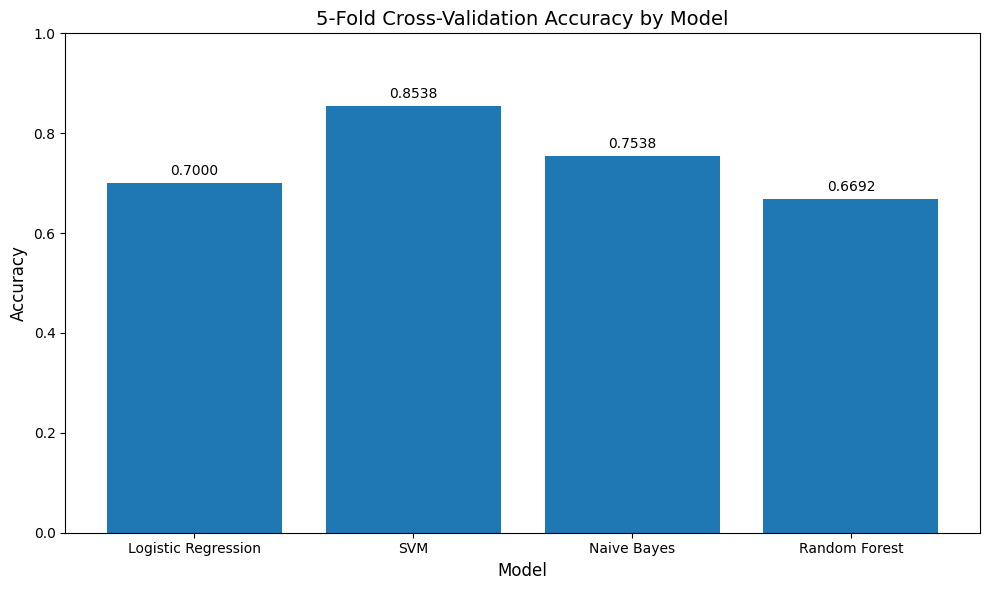


Bonus: BERT Embeddings Evaluation


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py", line 762, in fit
    self._count(X, Y)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py", line 889, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1827, in check_non_negative
    raise ValueError(f"Negative values in data passed to {whom}.")
ValueError: Negative values in data passed to MultinomialNB (input X).


In [6]:
# Import required libraries
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')  # Added to fix LookupError
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
data_path = 'data_stories_one_shot.csv'
data = pd.read_csv(data_path)

# Preprocessing function: lowercase, remove punctuation, tokenize, remove stop words, lemmatize
def preprocess_text(text):
    # Lowercase and remove punctuation
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    # Join tokens back to string
    return ' '.join(tokens)

# Apply preprocessing
data['cleaned_text'] = data['Sentence'].apply(preprocess_text)

# Create labels: Show (Stage 1) = 0, Tell (Stage 2 or 3) = 1
data['category'] = data['Stage'].apply(lambda x: 'Show' if x == 1 else 'Tell')
data['category_encoded'] = LabelEncoder().fit_transform(data['category'])

# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear'),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# 5-Fold Cross-Validation with TF-IDF
cv_results = {}
for name, clf in classifiers.items():
    pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('clf', clf)])
    scores = cross_val_score(pipeline, data['cleaned_text'], data['category_encoded'], cv=5, scoring='accuracy')
    cv_results[name] = scores.mean()

# Leave-One-Plot-Out Cross-Validation (Logistic Regression)
group_kfold = GroupKFold(n_splits=len(data['Plot_Name'].unique()))
pipeline_lr = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(max_iter=1000))])
lopo_scores = cross_val_score(
    pipeline_lr,
    data['cleaned_text'],
    data['category_encoded'],
    cv=group_kfold.split(data['cleaned_text'], data['category_encoded'], groups=data['Plot_Name']),
    scoring='accuracy'
)

# Display TF-IDF results
print("📊 5-Fold Cross-Validation Accuracy:")
for clf_name, acc in cv_results.items():
    print(f"{clf_name}: {acc:.4f}")

print(f"\n🔁 Leave-One-Plot-Out Accuracy (Logistic Regression): {lopo_scores.mean():.4f}")

# Visualize 5-Fold CV results as a bar plot (default Matplotlib colors)
plt.figure(figsize=(10, 6))
bars = plt.bar(cv_results.keys(), cv_results.values())
plt.title('5-Fold Cross-Validation Accuracy by Model', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Bonus: BERT Embeddings
print("\nBonus: BERT Embeddings Evaluation")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].squeeze().numpy())
    return np.array(embeddings)

# Get BERT embeddings
X_bert = get_bert_embeddings(data['cleaned_text'])
y_bert = data['category_encoded'].values

# 5-Fold Cross-Validation with BERT embeddings
bert_cv_results = {}
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_bert, y_bert, cv=5, scoring='accuracy')
    bert_cv_results[name] = scores.mean()

# Display BERT results
print("📊 5-Fold Cross-Validation Accuracy (BERT):")
for clf_name, acc in bert_cv_results.items():
    print(f"{clf_name}: {acc:.4f}")

# Visualize BERT CV results (default Matplotlib colors)
plt.figure(figsize=(10, 6))
bars = plt.bar(bert_cv_results.keys(), bert_cv_results.values())
plt.title('5-Fold Cross-Validation Accuracy by Model (BERT Embeddings)', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()